In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
#학습셋의 변형을 설정하는 부분입니다. 
train_datagen = ImageDataGenerator(rescale=1./255,          
                                   # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     
                            # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    
                                   # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   
                                   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        
                                   # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         
                               # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          
                                   # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,     
                                   # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      
                                   # 빈 공간을 채우는 방법입니다. 
                                #nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )  

train_generator = train_datagen.flow_from_directory('data/data2/train',
                                                  target_size=(150,150),
                                                  batch_size=5,
                                                  class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('data/data2/test',
                                                  target_size=(150,150),
                                                  batch_size=5,
                                                  class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [6]:
transfer_model = VGG16(weights='imagenet', include_top=False,
                       input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dense(64, Activation('relu')))
finetune_model.add(layers.Dropout(0.5))
finetune_model.add(layers.Dense(1, Activation('sigmoid')))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
finetune_model.compile(loss='binary_crossentropy', 
                       optimizer=optimizers.Adam(learning_rate=0.0002),
                       metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [12]:
history = finetune_model.fit(
       train_generator,
       epochs=20,
       validation_data=test_generator,
       callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 16s 503ms/step - loss: 0.7201 - accuracy: 0.5625 - val_loss: 0.6262 - val_accuracy: 0.5583
Epoch 2/20
32/32 [==============================] - 16s 515ms/step - loss: 0.5858 - accuracy: 0.7125 - val_loss: 0.5310 - val_accuracy: 0.8167
Epoch 3/20
32/32 [==============================] - 16s 513ms/step - loss: 0.5012 - accuracy: 0.7937 - val_loss: 0.4562 - val_accuracy: 0.8667
Epoch 4/20
32/32 [==============================] - 16s 511ms/step - loss: 0.4401 - accuracy: 0.8000 - val_loss: 0.4235 - val_accuracy: 0.8500
Epoch 5/20
32/32 [==============================] - 17s 546ms/step - loss: 0.4285 - accuracy: 0.8250 - val_loss: 0.3764 - val_accuracy: 0.8833
Epoch 6/20
32/32 [==============================] - 16s 490ms/step - loss: 0.3563 - accuracy: 0.8750 - val_loss: 0.3363 - val_accuracy: 0.8917
Epoch 7/20
32/32 [==============================] - 16s 514ms/step - loss: 0.3391 - accuracy: 0.8750 - val_loss: 0.3448 - val_accuracy: 0.8417

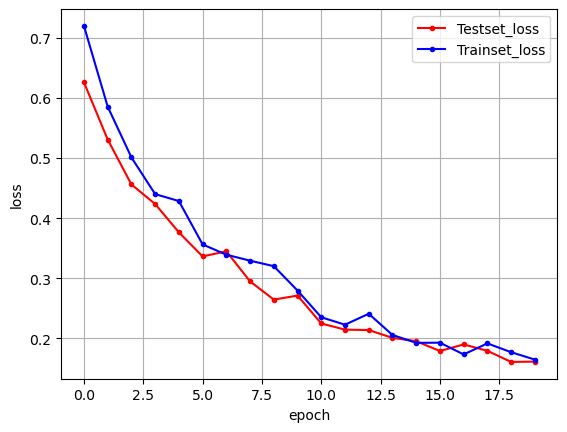

In [14]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()